# Spectral Analysis

*March 12, 2024*

Today's lesson will provide you with an overview of methods for working with spectral data. We will talk about different ways dealing with real-life issues that you will encounter when working with remotely sensed spectral data. Topics covered today will include:

- Topographic corrections (provided for you)
- Brightness normalization
- Mixing spaces
- Principal component analysis
- Spectral angles and spectral angle mapper

We will also introduce some new functions:

- `np.rollaxis` for moving a given NumPy axis from one position to another, e.g., an array with shape (x, m, n) becomes (m, n, x).
- `np.apply_along_axis` for applying a function along a given axis, with optional extra arguments to the applied function.
- `PCA` for computing principal components from an image: `from sklearn.decomposition import PCA`


# What is spectral information?

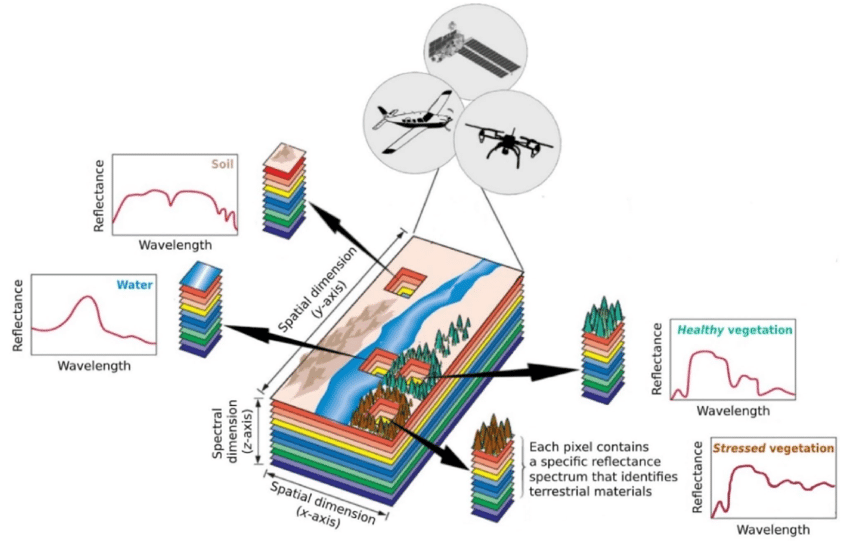

#### Things that need to be accounted for:
- Atmosphere
- Radiometric calibration
- Topography
- Glint (if working over water)
- Bidirectional reflectance (how light reflects off different surfaces. CAN BE SEEN IN THE BELOW THREE IMAGES)


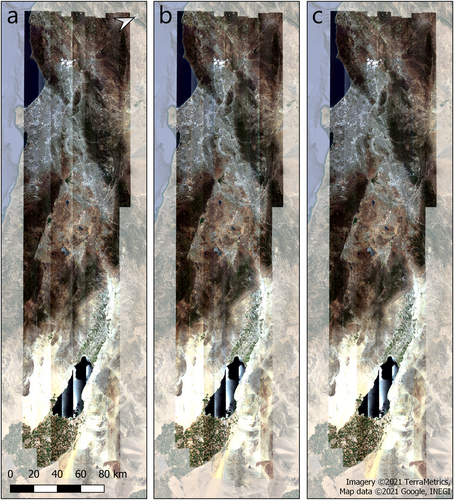

*Image from Queally, 2020*


In [1]:
import rasterio as rio
import numpy as np
import scipy.stats
from scipy.optimize import nnls
import matplotlib.pyplot as plt

# Specify file paths

# Surface reflectance
reflectance_file = "data/f140603t01p00r10_geocorr_clipped.dat"

# Ancillary data
obs_ort_file = "data/f140603t01p00r10_obs_ort_geocorr_clipped.dat"

# Create open datasets for both reflectance and ancillary data
obs_data = rio.open(obs_ort_file)
refl_data = rio.open(reflectance_file)

In [2]:
refl_data.meta

{'driver': 'ENVI',
 'dtype': 'float32',
 'nodata': -9999.0,
 'width': 728,
 'height': 977,
 'count': 224,
 'crs': CRS.from_epsg(32611),
 'transform': Affine(13.9984336538462, -0.0, 292924.7068,
        -0.0, -13.9985358239511, 4170089.3864)}

In [3]:
obs_data.meta

{'driver': 'ENVI',
 'dtype': 'float32',
 'nodata': -9999.0,
 'width': 728,
 'height': 977,
 'count': 9,
 'crs': CRS.from_epsg(32611),
 'transform': Affine(13.9984336538462, -0.0, 292924.7068,
        -0.0, -13.9985358239511, 4170089.3864)}

In [4]:
obs_data.descriptions

('path length',
 'to-sensor azimuth',
 'to-sensor zenith',
 'to-sun azimuth',
 'to-sun zenith',
 'phase',
 'slope',
 'aspect',
 'UTC time')

In [8]:
refl_data.descriptions[0:5]

('Band 1 (365.9136593 nanometers)',
 'Band 2 (375.5776593 nanometers)',
 'Band 3 (385.2466593 nanometers)',
 'Band 4 (394.9196593 nanometers)',
 'Band 5 (404.5966593 nanometers)')

In [6]:
band_numbers = list(range(1, len(obs_data.descriptions) + 1))
band_lookup = dict(
    zip(obs_data.descriptions, band_numbers))
band_lookup

{'path length': 1,
 'to-sensor azimuth': 2,
 'to-sensor zenith': 3,
 'to-sun azimuth': 4,
 'to-sun zenith': 5,
 'phase': 6,
 'slope': 7,
 'aspect': 8,
 'UTC time': 9}

In [9]:
band_lookup['slope']

7

In [10]:
# red is index 27
# green 18
# blue 10
raw_reflectance = refl_data.read()
rgb = np.rollaxis(raw_reflectance[[27,18,10],:,:], 0, 3)
rgb.shape

(977, 728, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


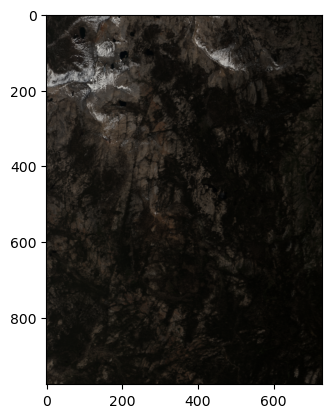

In [12]:
plt.imshow(rgb)

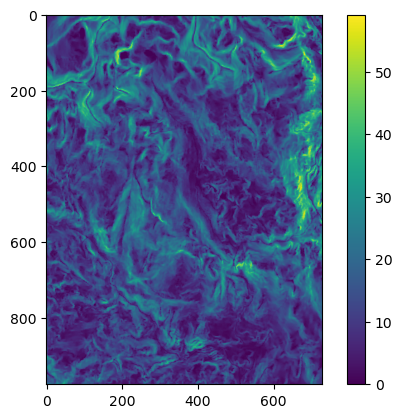

In [11]:
plt.imshow(obs_data.read(band_lookup['slope']))
plt.colorbar()

# Using ancillary data for correcting topographic shading effects

Below I've gone through and implemented "Sun-Canopy-Sensor+C" topographic corrections as outlined in [Soenen, 2005](https://people.uleth.ca/~craig.coburn/01499030.pdf). We're not going to cover this in detail, just know that it takes reflectance data and ancillary data, does some trigonometry based on radiation physics, and corrects the reflectance data so that steeply-sloped pixels looks more like a flat surface, which makes pixels more comparable to each other. I've found that reading code translated from a paper can be a great learning tool, which is the main reason for including this here.

In [13]:

def calc_cosine_i(obs_data, band_lut):
    """
    obs_data: open rasterio dataset
    band_lut: dictionary of flavor {"band name": band number}
    
    Calculates the cosine of the viewing angle of each pixel relative
    to the sensor and sun position.

    Returns array of cos(i) given ancillary data.

    Equation not included in Soenen.

    returns float np.ndarray

    """
    
    aspect_radians = np.radians(obs_data.read(band_lut["aspect"]))
    solar_azimuth_radians = np.radians(obs_data.read(band_lut["to-sun azimuth"]))
    solar_zenith_radians = np.radians(obs_data.read(band_lut["to-sun zenith"]))
    slope_radians = np.radians(obs_data.read(band_lut["slope"]))

    relative_azimuth = solar_azimuth_radians - aspect_radians
    cosine_i = np.cos(solar_zenith_radians)*np.cos(slope_radians) \
             + np.sin(solar_zenith_radians)*np.sin(slope_radians) * np.cos(relative_azimuth)
    return cosine_i

def make_mask(refl_data, obs_data, band_lut, cosine_i, min_ndvi=0.1, min_slope = 5, min_cos_i = 0.12):
    """
    refl_data: open rasterio reflectance dataset
    obs_data: open rasterio ancillary dataset
    band_lut: band lookup table dictionary
    cosine_i: cosine_i array matching the number of rows and cols as refl and obs

    
    Given reflectance dataset, an ancillary dataset, cosine i data, and masking thresholds,
    compute a boolean mask for computing topographic coefficients. We use this because,
    depending on the environment we are in, we may use different methods for computing
    topographic coefficients. For example, the method we use today primarily works on 
    forest ecosystems, so we will employ an NDVI mask when we compute topographic
    correction coefficients.

    Returns boolean np.ndarray
    """

    ### band numbers correspond to original dataset's red and nir bands
    red_data = refl_data.read(28)
    nir_data = refl_data.read(54)
    ndvi = (red_data - nir_data)/(red_data + nir_data)
    ndvi_mask = ndvi > min_ndvi
    
    slope = obs_data.read(band_lut["slope"])
    slope_mask = slope > min_slope

    cos_i_mask = cosine_i > min_cos_i

    mask = (slope_mask) & (ndvi_mask) & (cos_i_mask)

    return mask

def compute_topo_corr_coeffs(refl_data, obs_data, band_lut, mask):
    """
    refl_data: open rasterio reflectance dataset
    obs_data: open rasterio ancillary dataset
    band_lut: band lookup table dictionary
    mask: boolean mask array matching the number of rows and cols as refl and obs

    Compute C coefficients for each band, based on observation characteristics.

    returns 1d np array of length corresponding to the number of bands.

    """
    
    coeffs = []
    
    ### Compute cosine i so we can relate it to reflectance of each band
    cosine_i = calc_cosine_i(obs_data, band_lut)[mask].flatten()

    ### Need to expand dims along axis 1 to meet shape expectations of our model
    cosine_i = np.expand_dims(cosine_i,axis=1)
    X = np.concatenate([cosine_i, np.ones(cosine_i.shape)],axis=1)

    ### Let's compute the topographic correction coefficient C for each band
    for band_index in range(refl_data.meta["count"]):
        
        band_number = band_index + 1

        # read data in
        band_data = refl_data.read(band_number)

        # mask the data and flatten so we can do stats
        y = band_data[mask].flatten() 

        ### Compute C, using non-negative least squares.
        ### C is the ratio of the intercept to the slope of the regression
        ### between each band and the illumination angle,
        ### essentially acting as an attenuation factor for diffuse radiation.

        # Solve regression (eq. 7)
        slope, intercept = nnls(X, y)[0].flatten()

        # compute C (eq. 8)
        c = intercept/slope

        # if slope is super duper close to 0, we'll just say that the
        # ratio of intercept to slope is super high. This works fine.
        if not np.isfinite(c):
            c = 100000.0
        coeffs.append(c)
    return np.array(coeffs)
    
def calc_scsc_c1(obs_data, band_lut):
    """
    obs_data: open rasterio ancillary dataset
    band_lut: band lookup table dictionary
    
    Computes the left side of the numerator in equation 11

    returns float np ndarray
    """
    solar_zenith_radians = np.radians(obs_data.read(band_lut["to-sun zenith"]))
    slope_radians = np.radians(obs_data.read(band_lut["slope"]))
    scsc_c1 = np.cos(solar_zenith_radians) * np.cos(slope_radians)
    return scsc_c1

def correct(obs_data, refl_data, band_lut):
    """ 
    refl_data: open rasterio reflectance dataset
    obs_data: open rasterio ancillary dataset
    band_lut: band lookup table dictionary
    
    Compute corrected reflectance and return the correct data as an array

    returns float np ndarray with the same shape as refl_data
    """

    cosine_i = calc_cosine_i(obs_data, band_lut)
    mask = make_mask(refl_data, obs_data, band_lut, cosine_i)

    ### compute c values
    coeffs = compute_topo_corr_coeffs(refl_data, obs_data, band_lut, mask)

    ### Compute left side of numerator
    c1 = calc_scsc_c1(obs_data, band_lut)

    ### Set up correction array for each pixel in our data
    correction_factor = np.ones((refl_data.meta["count"], refl_data.meta["height"], refl_data.meta["width"]))
    for i, v in enumerate(coeffs):
        ### Compute correction factors for all bands across every pixel
        correction_factor[i,:,:] = (c1 + v)/(cosine_i + v)
    uncorrected_refl = refl_data.read()

    ### Apply correction factors
    corrected_refl = uncorrected_refl*correction_factor
    return corrected_refl
    

In [15]:
corrected_reflectance = correct(obs_data, refl_data, band_lookup)

C:\Users\by197116\AppData\Local\Temp\ipykernel_17284\2751094529.py:102: RuntimeWarning: divide by zero encountered in double_scalars
  c = intercept/slope


In [18]:
# Now we have topographically corrrected reflectance,
# We can verify it has the same shape as the raw reflectance
corrected_reflectance.shape

(224, 977, 728)

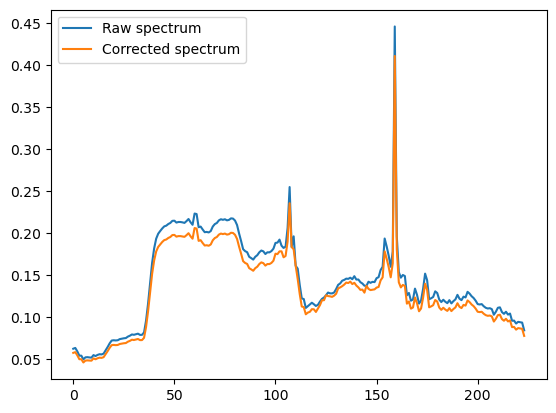

In [16]:
import matplotlib.pyplot as plt

### Extract spectra of single pixel for raw and topo-corrected reflectance
veg_raw_spectra = raw_reflectance[:,500,300]
veg_corr_spectra = corrected_reflectance[:,500,300]

plt.clf()
plt.plot(veg_raw_spectra, label = "Raw spectrum")
plt.plot(veg_corr_spectra, label = "Corrected spectrum")
plt.legend()
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


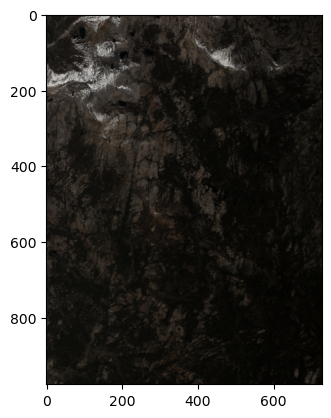

In [20]:
rgb = np.rollaxis(corrected_reflectance[[27,18,10],:,:], 0, 3)
plt.imshow(rgb)

$$C = \sqrt{A^2 + B^2}$$

$$C = \sqrt{A^2 + B^2 + ... + N^2}$$

In [22]:
# Make a euclidean norm (l2 norm) function to divide bright pixels by large
# values and dark pixels by small values

In [24]:
### These are wavelengths that correspond to water absorption in the atmosphere.
### The "reflectance" values we get for these bands are essentially noise, so we will remove those
### bands from our dataset. This chunk just creates a boolean mask along the band dimension
### that we can use to subset our bands to only include "good" bands.
bad_regions = [[300,400],
               [1337,1430],
               [1800,1960],
               [2450,2600]]

### Initialize empty lists to store our "bad" bands, and 
### Each wavelength as an actual number instead of a string
bad_bands = []
waves = []

### For each wavelength, if it is greater than the minimum of
### a bad band region and less than the maximum, add "True" to the bad band
### list. At the end, outside of the loop, we invert this to have a 
### "good band". While we're doing this, we also create a list called "waves"
### of wavelengths for each "good" band, which we then use to subset our
### topographically corrected reflectance.
for wavelength_string in refl_data.descriptions:
    wavelength = int(float((wavelength_string.split(" ")[2].split("(")[1])))
    waves.append(wavelength)
    bad=False
    for start,end in bad_regions:
        bad = ((wavelength >= start) & (wavelength <=end)) or bad
    bad_bands.append(bad)

### Define "good_bands", "waves", and corrected refl without
### the water absorption bands
good_bands = ~np.array(bad_bands)
waves = np.array(waves)[good_bands]
corr_refl_no_water_bands = corrected_reflectance[good_bands,:,:]

nir_band = np.argmin(abs(waves - 760)) # the numbers here represent nanometers
red_band = np.argmin(abs(waves - 630))
green_band = np.argmin(abs(waves - 540))
blue_band = np.argmin(abs(waves - 465))


In [25]:
# Let's check out the new band numbers
print(red_band, green_band, blue_band, nir_band)

23 14 6 39


In [26]:
def euclidean_norm(x):
    return np.sqrt(np.sum(x**2))

# Let's get the euclidean norm of every pixel
norm = np.apply_along_axis(euclidean_norm, 0, corr_refl_no_water_bands)
norm.shape

(977, 728)

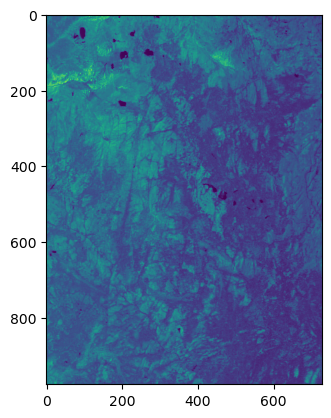

In [27]:
plt.imshow(norm)

In [34]:
# Name stands for reflectance vector normalize
refl_vn = corr_refl_no_water_bands/norm
rgb_vn = np.rollaxis(refl_vn[[red_band, green_band, blue_band], :, :], 0, 3) * 10
# Multiply by 10 for display purposes

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


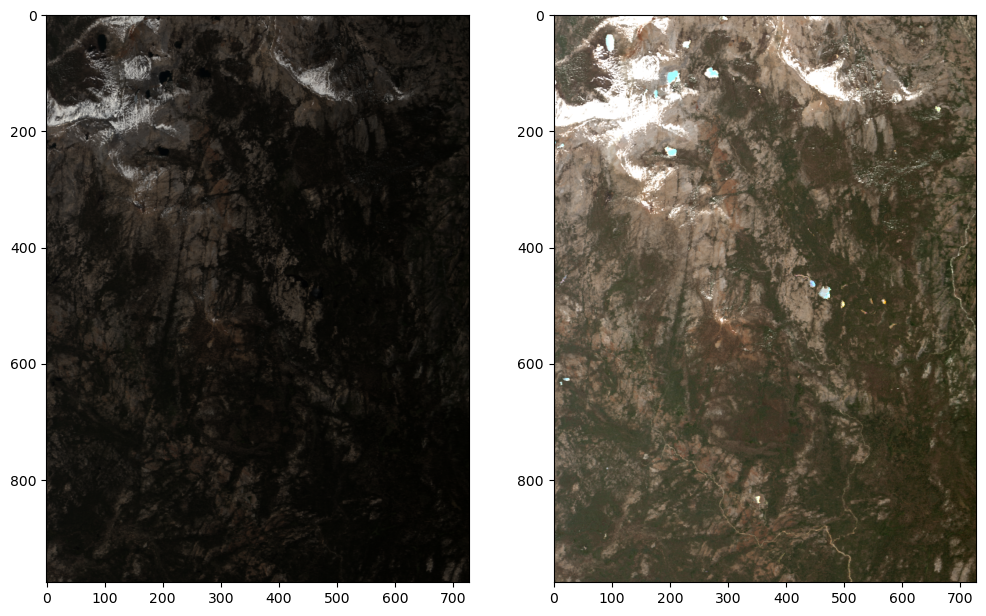

In [35]:
plt.figure(figsize = (12, 8))
plt.subplot(121)
plt.imshow(rgb)
plt.subplot(122)
plt.imshow(rgb_vn)

<Figure size 640x480 with 0 Axes>

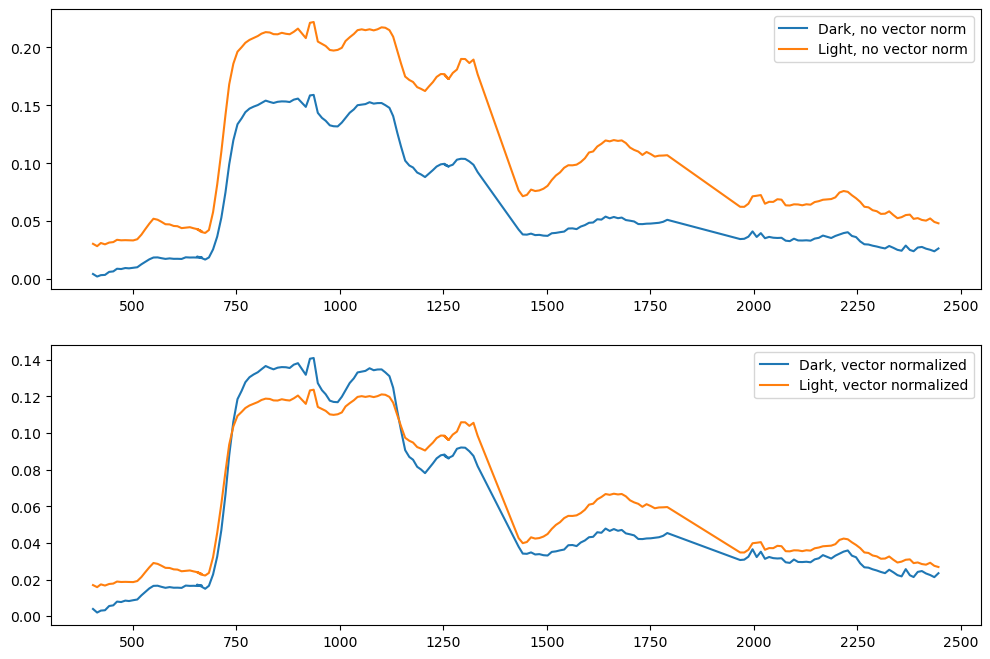

In [36]:
plt.clf()
plt.figure(figsize = (12, 8))
plt.subplot(211) # e.g., "121" means 1 row, 2 columns, 1st image
plt.plot(waves,corr_refl_no_water_bands[:,921,671], label = "Dark, no vector norm")
plt.plot(waves,corr_refl_no_water_bands[:,718,94], label = "Light, no vector norm")
plt.legend()
plt.subplot(212)
plt.plot(waves,refl_vn[:,921,671], label = "Dark, vector normalized")
plt.plot(waves,refl_vn[:,718,94], label = "Light, vector normalized")
plt.legend()

# Mixing spaces and Principal Components Analysis

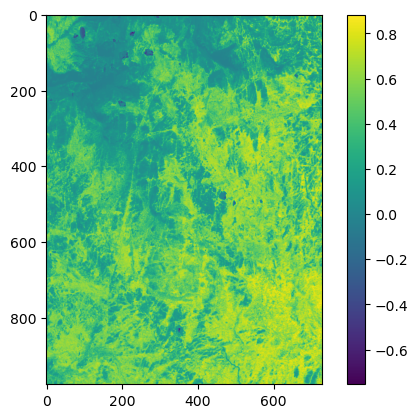

In [39]:
red = refl_vn[red_band, :, :]
nir = refl_vn[nir_band, :, :]
ndvi = (nir - red) / (nir + red)
plt.imshow(ndvi)
plt.colorbar()

Text(0, 0.5, 'NIR Intensity')

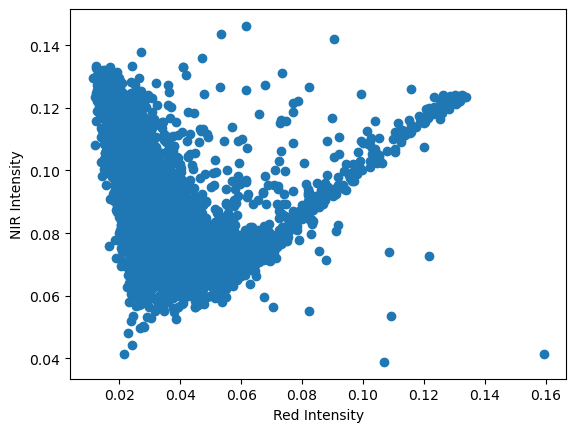

In [41]:
idx = np.random.randint(0, red.shape[1]*red.shape[0], size = 5000)
red_sample = red.flatten()[idx]
nir_sample = nir.flatten()[idx]

# Plotting 'mixing space'
plt.clf()
plt.scatter(red_sample, nir_sample)
plt.xlabel('Red Intensity')
plt.ylabel('NIR Intensity')


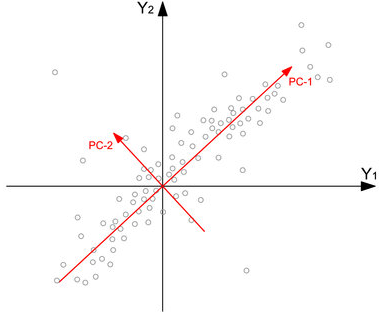


In [44]:
from sklearn.decomposition import PCA

In [45]:
# To create a new principal component analysis, we have to create a pca object
pca = PCA(n_components = 3)

data = refl_vn.reshape((refl_vn.shape[0], refl_vn.shape[1]*refl_vn.shape[2])).T
data.shape

(711256, 187)

In [46]:
idx = np.random.randint(0, data.shape[0], size = 50000)
pca.fit(data[idx,:]) # Expects a matrix in which row = observation, column = variable
print(pca.explained_variance_ratio_)
print(pca.explained_variance_ratio_.sum())

[0.62190857 0.31683656 0.03228511]
0.9710302409254454


In [49]:
# We see above that the first 2 PCs explain 97% of the variance
# Now we want to go re-transform the data into geographic space rather than PCA space
# pca.transform(data).shape # This is the dimensions it will be
data2 = pca.transform(data).reshape((refl_vn.shape[1], refl_vn.shape[2], 3))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'RGB Composite of first 3 PCs')

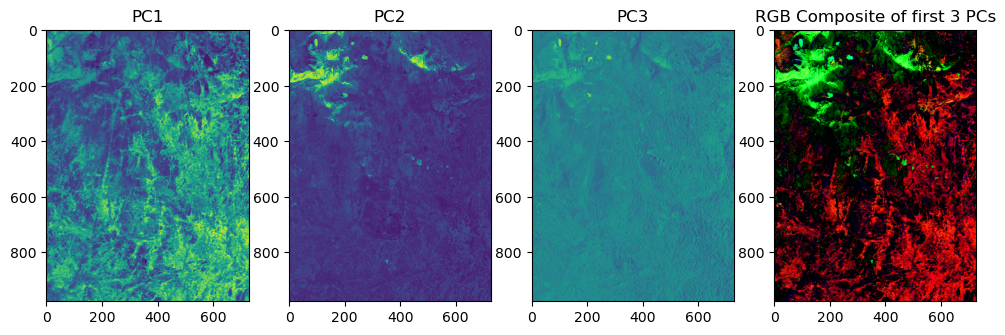

In [50]:
comps = [data2[:,:,0], data2[:,:,1], data2[:,:,2]]
plt.figure(figsize = (12, 8))
for pc in range(0, 3):
    plt.subplot(141 + pc) # e.g., "141" means 1 row, 4 columns, 1st image
    plt.imshow(comps[pc])
    plt.title(f'PC{pc+1}')
plt.subplot(144)
plt.imshow(np.dstack(comps)*3)
plt.title("RGB Composite of first 3 PCs")

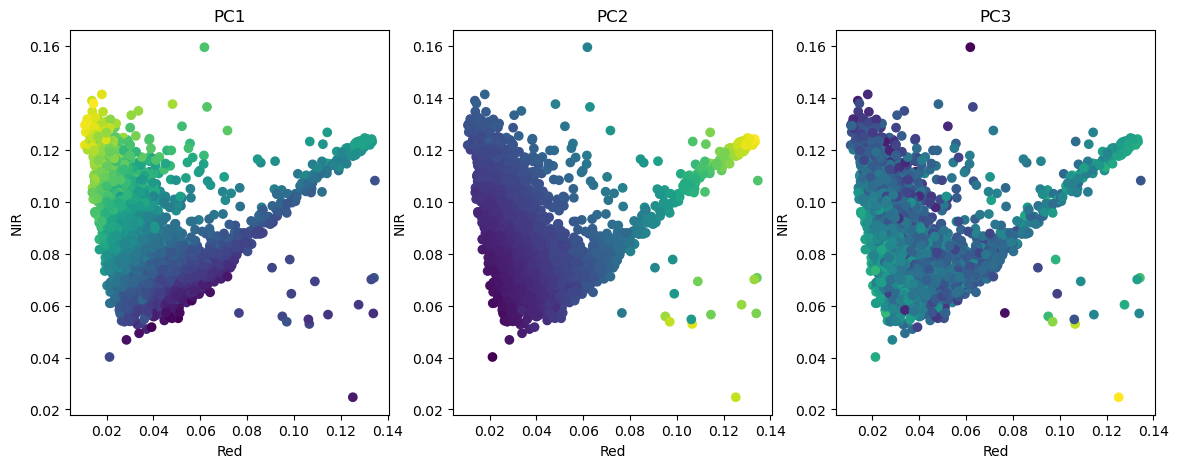

In [51]:
idx = np.random.randint(0, red.shape[1]*red.shape[0], size = 5000)
plt.figure(figsize = (14, 5))
for pc in range(0, 3):
    plt.subplot(131 + pc) # e.g., "131" means 1 row, 3 columns, 1st image
    plt.scatter(red.ravel()[idx], nir.ravel()[idx], c=comps[pc].ravel()[idx])
    plt.xlabel("Red")
    plt.ylabel("NIR")
    plt.title(f'PC{pc+1}')


# Spectral Angle Mapper

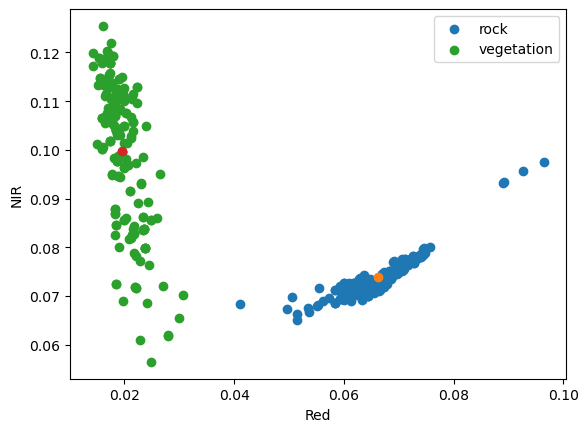

In [52]:
# Finding rocks
rock_red = refl_vn[red_band,0:20,200:210].flatten()
rock_nir = refl_vn[nir_band,0:20,200:210].flatten()
veg_red = refl_vn[red_band,900:920,600:610].flatten()
veg_nir = refl_vn[nir_band,900:920,600:610].flatten()

plt.scatter(rock_red, rock_nir, label = "rock")
plt.scatter(rock_red.mean(), rock_nir.mean())
plt.scatter(veg_red, veg_nir, label = "vegetation")
plt.scatter(veg_red.mean(), veg_nir.mean())
plt.xlabel("Red")
plt.ylabel("NIR")
plt.legend()

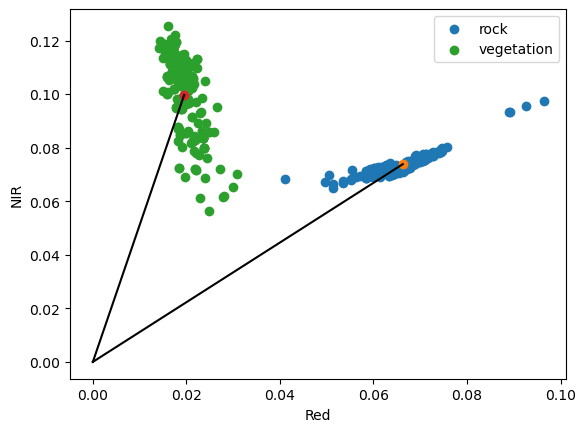

In [53]:
# If we drew lines from the mean of rock and the mean of vegetation to intersect 0
plt.scatter(rock_red, rock_nir, label = "rock")
plt.scatter(rock_red.mean(), rock_nir.mean())
plt.plot([0, rock_red.mean()], [0, rock_nir.mean()], color = "black")
plt.scatter(veg_red, veg_nir, label = "vegetation")
plt.scatter(veg_red.mean(), veg_nir.mean())
plt.plot([0, veg_red.mean()], [0, veg_nir.mean()], color = "black")
plt.xlabel("Red")
plt.ylabel("NIR")
plt.legend()

Text(0.5, 0, 'wavelength (nm)')

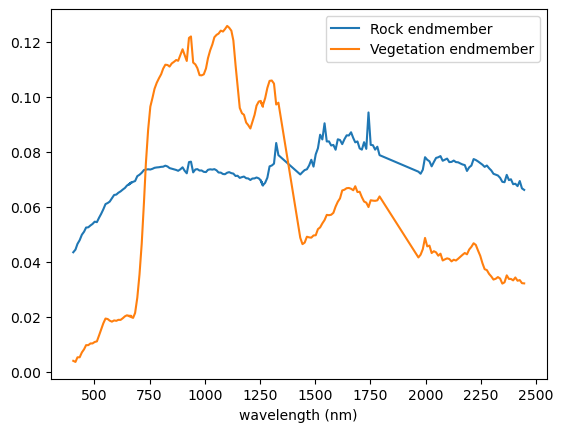

In [59]:
# Endmember is a reference spectrum to compare pixels to
rock_endmember = refl_vn[:,0:20,200:210].mean(axis = (1,2)) # Collapse the rows and columns
# Collapsing is taking the average value at every wavelength
veg_endmember = refl_vn[:,900:920,600:610].mean(axis = (1,2))
plt.plot(waves, rock_endmember, label = "Rock endmember")
plt.plot(waves, veg_endmember, label = "Vegetation endmember")
plt.legend()
plt.xlabel('wavelength (nm)')

In [61]:
# We're going to apply this spectral angle mapper function
# Computing a multidimensional angle between a candidate pixel and an endmember
def sam(s1, s2):
    v1_u = euclidean_norm(s1)
    v2_u = euclidean_norm(s2)
    return np.arccos(np.dot(s1, s2)/(v1_u*v2_u))

rock_angles = np.apply_along_axis(sam, 0, refl_vn, s2 = rock_endmember)
veg_angles = np.apply_along_axis(sam, 0, refl_vn, s2 = veg_endmember)

In [62]:
rock_angles.shape

(977, 728)

In [63]:
veg_angles.shape

(977, 728)

In [65]:
# These (above) are just arrays of angles
# To move to maps from angles, we ned to set a threshhold
# If the angle is small, we'll call it rock
# If the angle is big, we'll call it something else

max_thresh_rock = rock_angles[0:20, 200:210].max()
max_thresh_veg = veg_angles[900:920, 600:610].max()
rock_map = np.where(rock_angles < max_thresh_rock, 1, 0)
veg_map = np.where(veg_angles < max_thresh_veg, 1, 0)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'Vegetation')

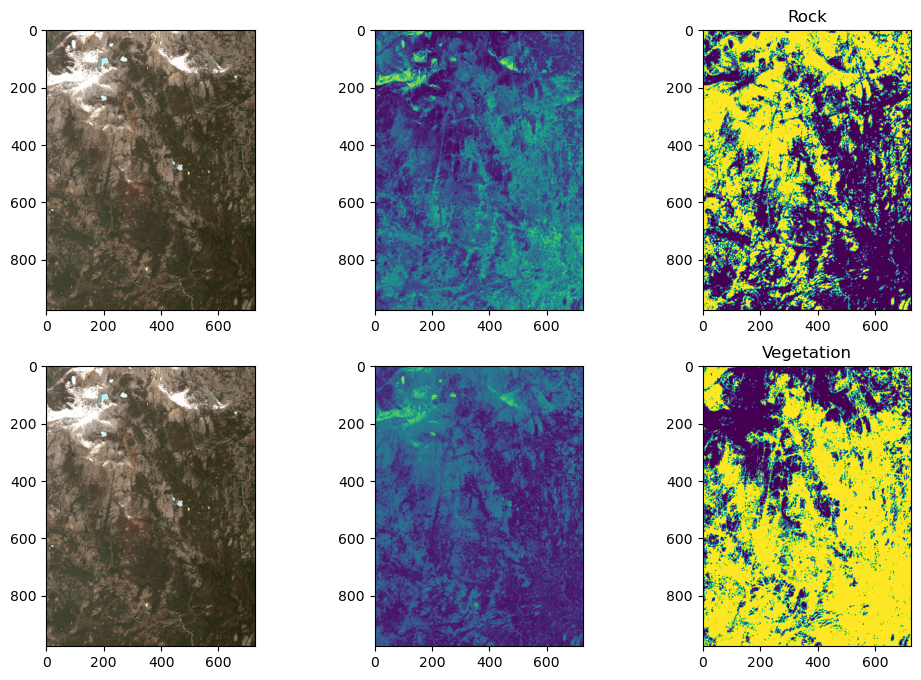

In [66]:
plt.figure(figsize = (12, 8))
plt.subplot(231)
plt.imshow(rgb_vn)
plt.subplot(232)
plt.imshow(rock_angles)
plt.subplot(233)
plt.imshow(rock_map)
plt.title("Rock")
plt.subplot(234)
plt.imshow(rgb_vn)
plt.subplot(235)
plt.imshow(veg_angles)
plt.subplot(236)
plt.imshow(veg_map)
plt.title("Vegetation")